# Hypothesis Testing of Log-Return Normality

**Course**: 2025 Introduction to Quantitative Methods in Finance  
**Institute**: The Erdös Institute

## Objective

This project investigates whether the **log returns** of individual stocks and portfolios follow a **normal distribution**, as assumed in many financial models.

### Approaches Explored:
1. Normality test over entire time series
2. Normality test after removing outliers
3. Rolling normality test over time
4. Brute-force portfolio optimization for normality
5. Visual diagnostics: Q-Q plots and histograms

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.stats as stats
import datetime as dt
from itertools import product
from scipy.stats import normaltest
import os

sns.set_style('darkgrid')
np.random.seed(1205)

## Utility Functions

In [37]:
def compute_log_returns(prices):
    """
    Computes daily log returns from a price series.

    Parameters:
        prices (pd.Series or pd.DataFrame): Price data

    Returns:
        pd.Series: Daily log returns
    """
    return np.log(prices / prices.shift(1)).dropna()

def normality_test_results(log_returns):
    """
    Applies D’Agostino and Pearson’s normality test.

    Parameters:
        log_returns (pd.Series): The series of log returns

    Returns:
        tuple: (p-value, 'Possibly Normal' or 'Not Normal')
    """
    p = stats.normaltest(log_returns)[1]
    conclusion = "Not Normal" if p < 0.05 else "Possibly Normal"
    return p, conclusion

def remove_outliers(data, z_thresh=2.5):
    """
    Removes data points that are Z-score outliers.

    Parameters:
        data (pd.Series): Data to filter
        z_thresh (float): Z-score threshold (default=2.5)

    Returns:
        np.ndarray: Filtered values
    """
    data = data.values.flatten()
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    return data[z_scores < z_thresh]

def test_normality_over_time(log_returns, window=126):
    """
    Performs rolling window normality test.

    Parameters:
        log_returns (pd.Series): Log return data
        window (int): Window size in days (default=126)

    Returns:
        list of tuples: (window index, start date, p-value)
    """
    results = []
    for i in range(0, len(log_returns) - window + 1, window):
        segment = log_returns[i:i + window]
        p_val = stats.normaltest(segment)[1]
        results.append((i, segment.index[0], p_val))
    return results

def generate_weight_combinations(n_assets, step=0.05):
    """
    Generates combinations of asset weights summing to 1.

    Parameters:
        n_assets (int): Number of assets
        step (float): Increment size for weights (default=0.05)

    Yields:
        tuple: Weight combination
    """
    from itertools import product
    grid = np.arange(0, 1 + step, step)
    for combo in product(grid, repeat=n_assets):
        if np.isclose(sum(combo), 1.0, atol=1e-4):
            yield combo

def compute_weighted_portfolio(log_return_dict, symbols, weights):
    """
    Computes portfolio log returns using weighted average.

    Parameters:
        log_return_dict (dict): Dictionary of log return Series
        symbols (list): List of stock tickers
        weights (list or array): Corresponding weights

    Returns:
        pd.Series: Combined portfolio log returns
    """
    weighted_returns = [
        weights[i] * log_return_dict[symbols[i]]
        for i in range(len(symbols))
    ]
    return pd.concat(weighted_returns, axis=1).dropna().sum(axis=1)

## Data Preparation

In [38]:
symbols = ['AAPL', 'TSLA', 'JNJ', 'NVDA', 'JPM', 'WMT', 'XOM', 'T']
start_date = dt.datetime(2015, 1, 1)
end_date = dt.datetime(2024, 12, 31)

log_return_dict = {}
p_value_summary = []

for sym in symbols:
    file_path = f"data/{sym}_close_prices_{start_date.date()}_{end_date.date()}.csv"
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # ← This fixes the issue
    else:
        df = yf.download(sym, start=start_date, end=end_date)
        if not df.empty:
            df[['Close']].to_csv(file_path)

    if df.empty or 'Close' not in df: continue

    log_ret = compute_log_returns(df['Close'])
    log_return_dict[sym] = log_ret
    p, conclusion = normality_test_results(log_ret)
    
    print(f"{sym}: p = {p:.4f}, {conclusion}")
    p_value_summary.append({'Symbol': sym, 'Overall p-value': np.round(p, 4), 'Conclusion': conclusion})

AAPL: p = 0.0000, Not Normal
TSLA: p = 0.0000, Not Normal
JNJ: p = 0.0000, Not Normal
NVDA: p = 0.0000, Not Normal
JPM: p = 0.0000, Not Normal
WMT: p = 0.0000, Not Normal
XOM: p = 0.0000, Not Normal
T: p = 0.0000, Not Normal


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_16806/2246594626.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col=0, parse_dates=True)
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_16806/2246594626.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col=0, parse_dates=True)
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_16806/2246594626.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col=0, parse_dates=True)
/var/folders/8y/

## Q-Q Plots

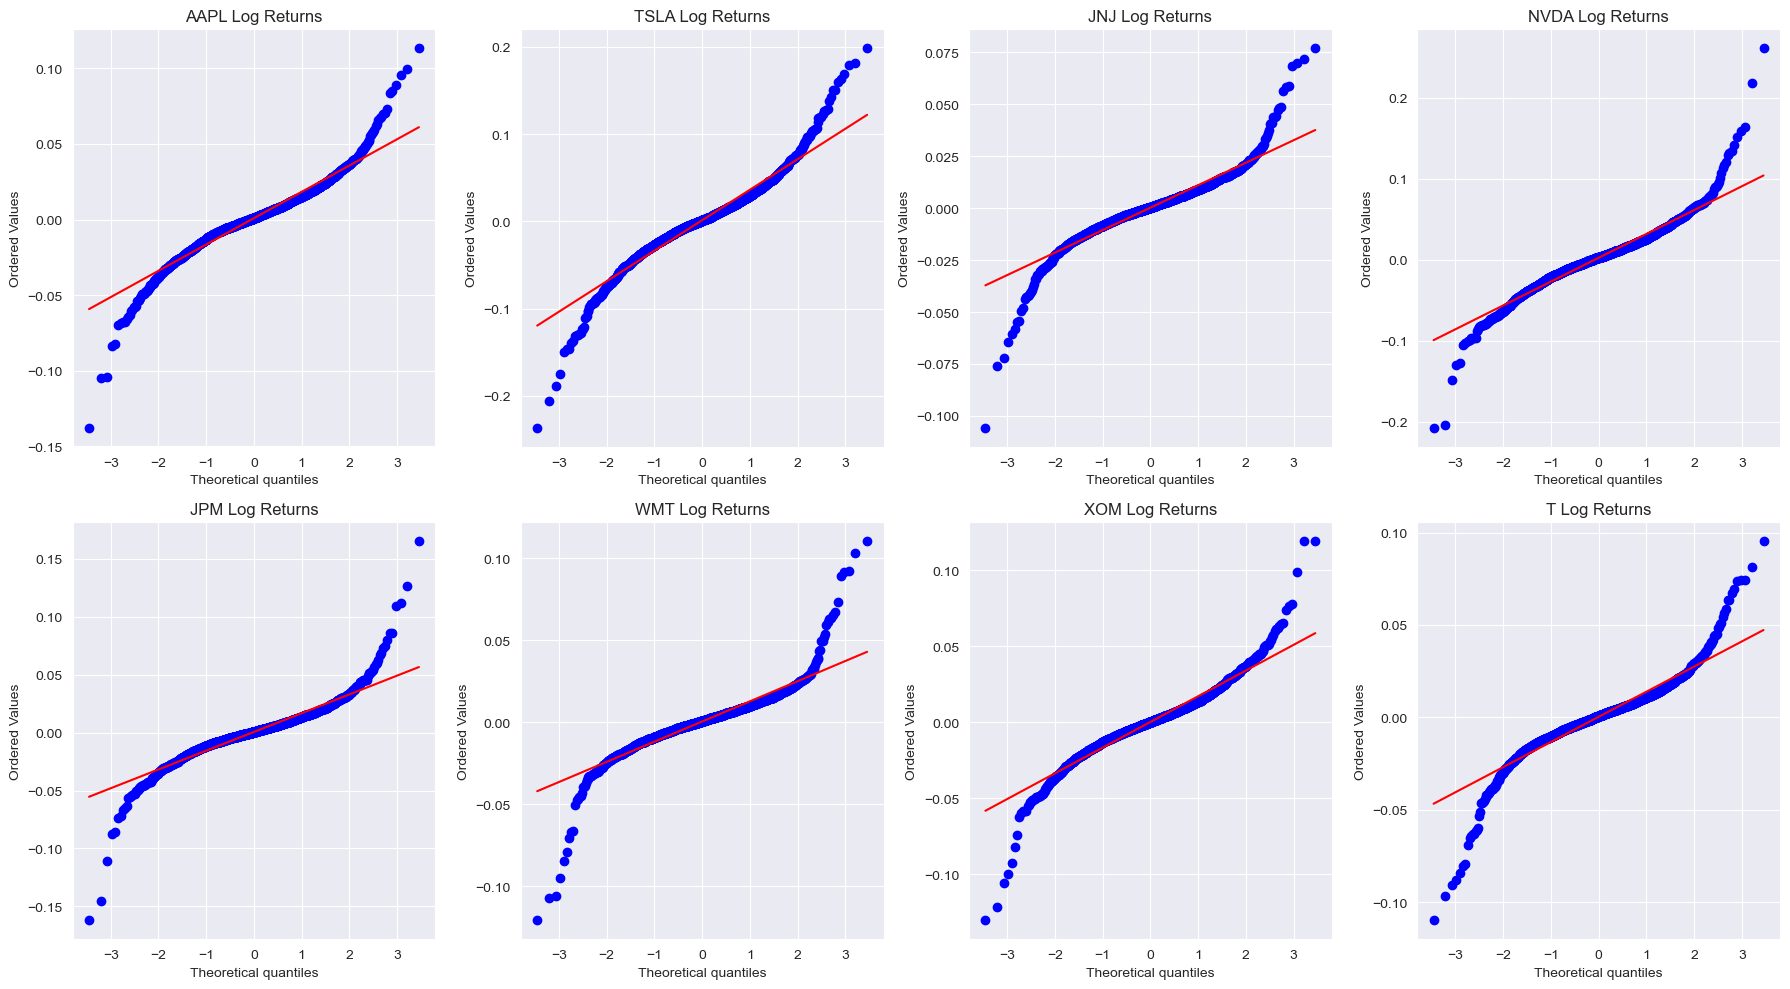

In [39]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()
for i, (sym, log_ret) in enumerate(log_return_dict.items()):
    stats.probplot(log_ret.values.flatten(), dist="norm", plot=axes[i])
    axes[i].set_title(f"{sym} Log Returns")
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

## Compare Outlier Filtering

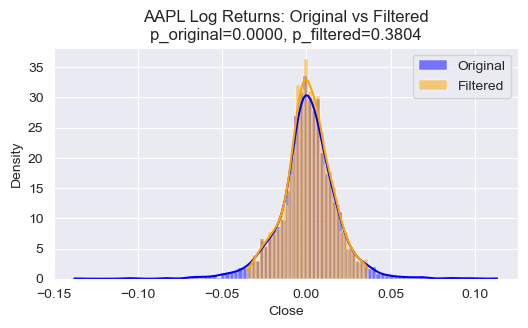

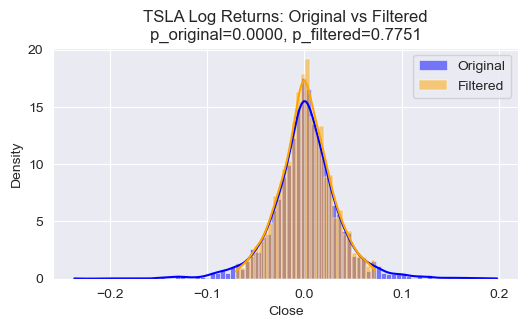

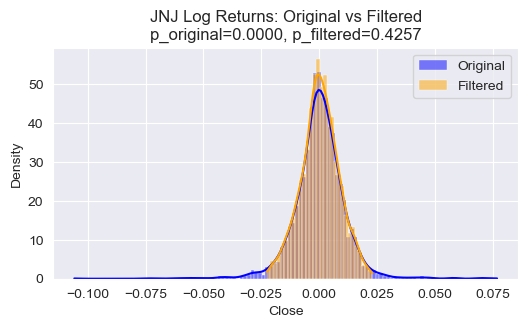

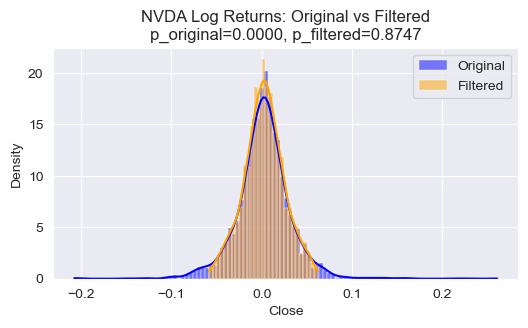

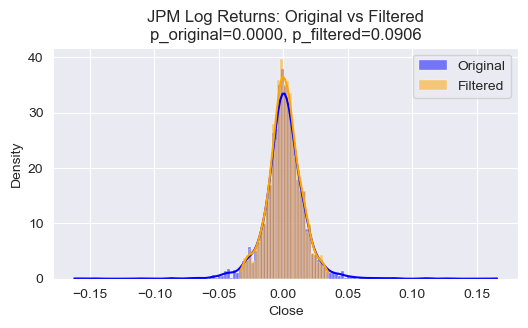

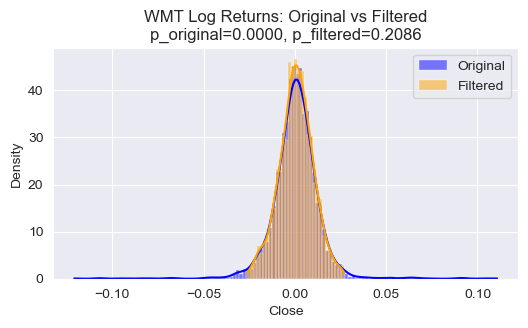

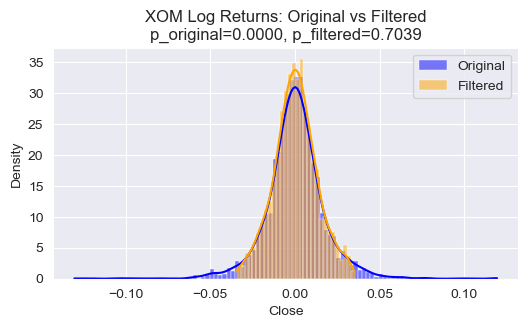

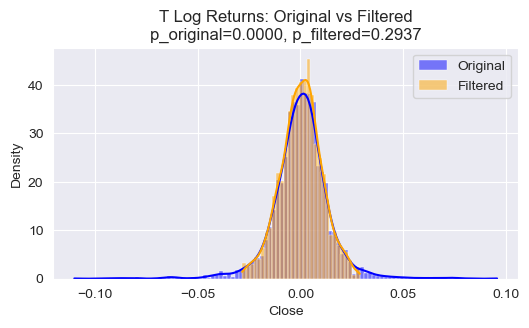

In [40]:
for sym in symbols:
    original = log_return_dict[sym]
    filtered = remove_outliers(original, z_thresh=2.0)

    p_original, _ = normality_test_results(original)
    p_filtered, _ = normality_test_results(filtered)

    plt.figure(figsize=(6, 3))
    sns.histplot(original, color='blue', label='Original', stat='density', kde=True)
    sns.histplot(filtered, color='orange', label='Filtered', stat='density', kde=True)
    plt.title(f"{sym} Log Returns: Original vs Filtered\np_original={p_original:.4f}, p_filtered={p_filtered:.4f}")
    plt.legend()
    plt.show()

## Rolling Normality for TSLA

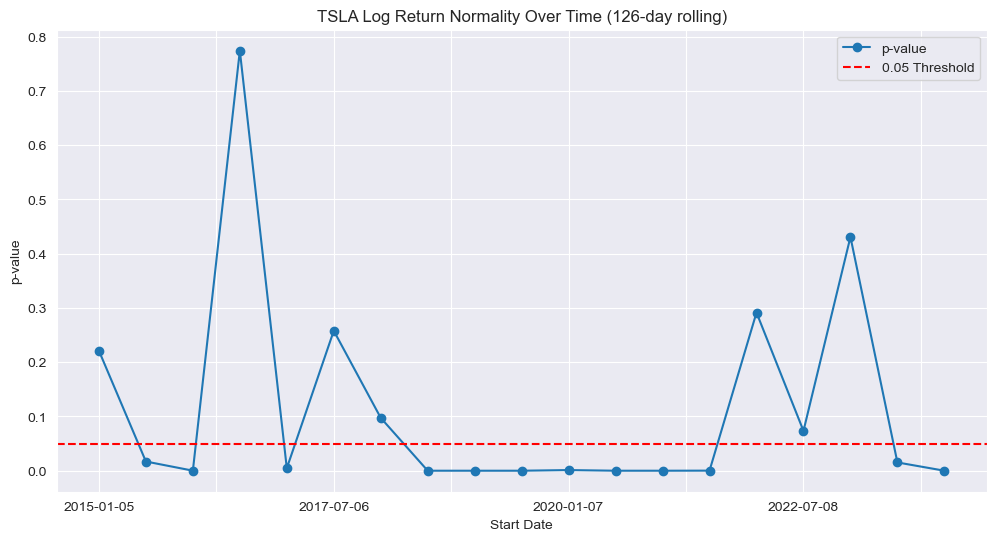

In [41]:
tsla_returns = log_return_dict['TSLA']
rolling_results = test_normality_over_time(tsla_returns, window=126)
rolling_df = pd.DataFrame(rolling_results, columns=["Window", "Start Date", "p-value"]).set_index("Start Date")
rolling_df["p-value"] = rolling_df["p-value"].astype(float)

plt.figure(figsize=(12, 6))
rolling_df["p-value"].plot(marker='o')
plt.axhline(0.05, color='red', linestyle='--', label='0.05 Threshold')
plt.title("TSLA Log Return Normality Over Time (126-day rolling)")
plt.ylabel("p-value")
plt.legend()
plt.show()

## Brute-force Portfolio Normality


Best *raw* weights: {'AAPL': 0.0, 'TSLA': 0.55, 'JNJ': 0.0, 'NVDA': 0.45} (p = 0.0000)
Best *filtered* weights: {'AAPL': 0.15000000000000002, 'TSLA': 0.05, 'JNJ': 0.0, 'NVDA': 0.8} (p = 0.9997)


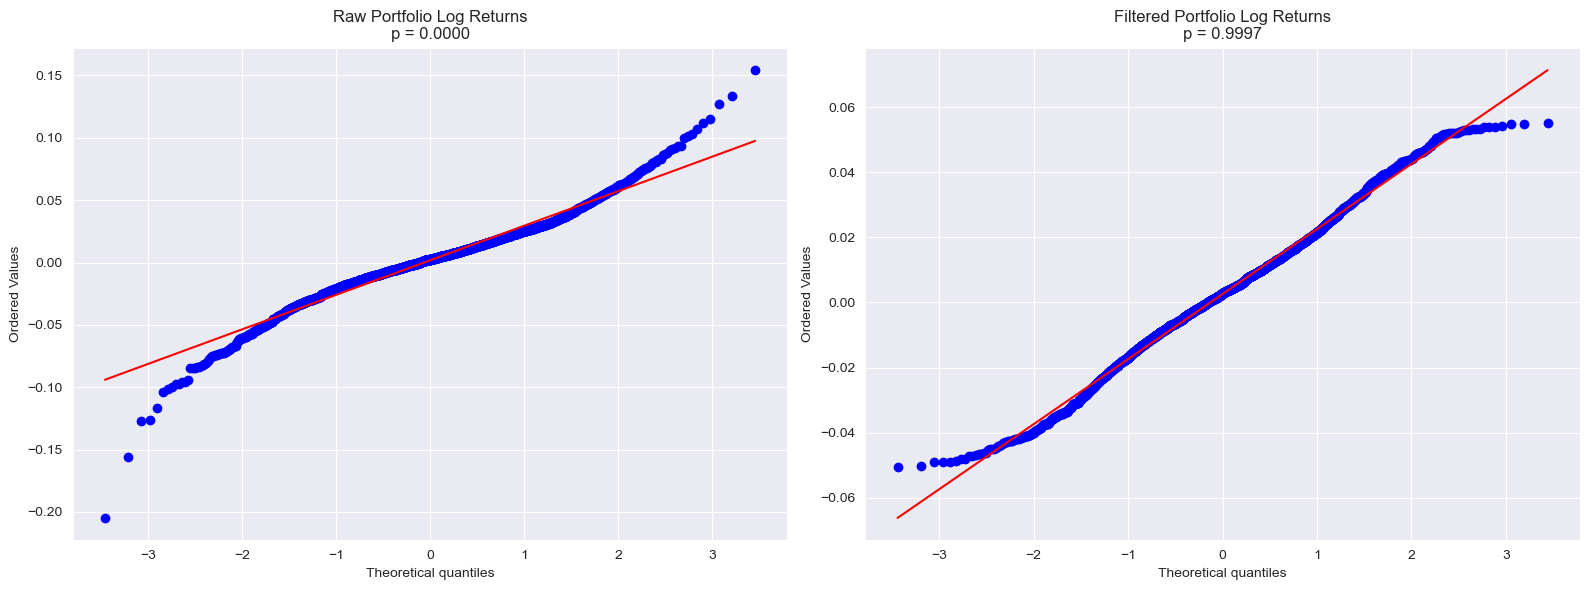

In [42]:
symbols_portfolio = ['AAPL', 'TSLA', 'JNJ', 'NVDA']
step = 0.05

best_p_raw, best_p_filtered = -np.inf, -np.inf
best_weights_raw, best_weights_filtered = None, None
best_returns_raw, best_returns_filtered = None, None

for weights in generate_weight_combinations(len(symbols_portfolio), step):
    returns = compute_weighted_portfolio(log_return_dict, symbols_portfolio, weights)
    returns_filtered = remove_outliers(returns, z_thresh=2.0)

    p_raw = normaltest(returns)[1]
    p_filtered = normaltest(returns_filtered)[1]

    if p_raw > best_p_raw:
        best_p_raw, best_weights_raw, best_returns_raw = p_raw, weights, returns

    if p_filtered > best_p_filtered:
        best_p_filtered, best_weights_filtered, best_returns_filtered = p_filtered, weights, returns_filtered

print(f"\nBest *raw* weights: {dict(zip(symbols_portfolio, best_weights_raw))} (p = {best_p_raw:.4f})")
print(f"Best *filtered* weights: {dict(zip(symbols_portfolio, best_weights_filtered))} (p = {best_p_filtered:.4f})")

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
stats.probplot(best_returns_raw, dist="norm", plot=axs[0])
axs[0].set_title(f"Raw Portfolio Log Returns\np = {best_p_raw:.4f}")
stats.probplot(best_returns_filtered, dist="norm", plot=axs[1])
axs[1].set_title(f"Filtered Portfolio Log Returns\np = {best_p_filtered:.4f}")
plt.tight_layout()
plt.show()

## Using the previous portfolios

In [43]:
# Load saved price data
price_data_file = "data/prices_2022-01-01_2024-12-31.csv"
data = pd.read_csv(price_data_file, index_col=0, parse_dates=True)

# Compute daily log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Load weights
output_dir = "portfolio_weights"
def load_weights(name):
    """Load weights from saved CSV."""
    df = pd.read_csv(f"{output_dir}/{name}_weights.csv")
    return df['Weight'].values

low_risk_weights = load_weights("low_risk")
high_risk_weights = load_weights("high_risk")
high_return_weights = load_weights("high_return")

In [44]:
# Compute weighted log returns
returns_low = log_returns.dot(low_risk_weights)
returns_high = log_returns.dot(high_risk_weights)
returns_high_return = log_returns.dot(high_return_weights)

# Run normality tests
def run_normality_test(name, returns):
    p = stats.normaltest(returns)[1]
    result = "Possibly Normal" if p > 0.05 else "Not Normal"
    print(f"{name} Portfolio: p = {p:.4f} → {result}")
    return p, result

p_low, _ = run_normality_test("Low-Risk", returns_low)
p_high, _ = run_normality_test("High-Risk", returns_high)
p_high_return, _ = run_normality_test("High-Return", returns_high_return)

Low-Risk Portfolio: p = 0.0000 → Not Normal
High-Risk Portfolio: p = 0.0000 → Not Normal
High-Return Portfolio: p = 0.0000 → Not Normal


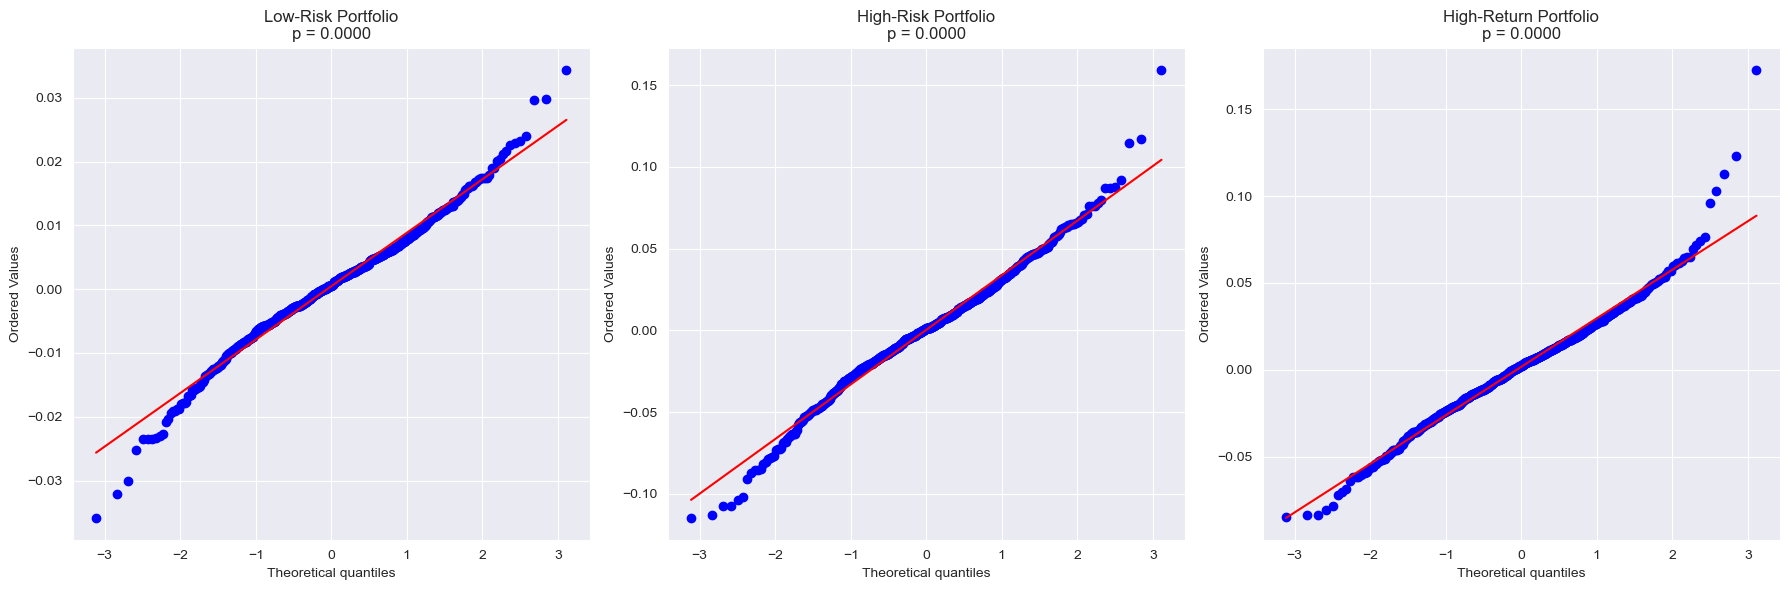

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

stats.probplot(returns_low, dist="norm", plot=axs[0])
axs[0].set_title(f"Low-Risk Portfolio\np = {p_low:.4f}")

stats.probplot(returns_high, dist="norm", plot=axs[1])
axs[1].set_title(f"High-Risk Portfolio\np = {p_high:.4f}")

stats.probplot(returns_high_return, dist="norm", plot=axs[2])
axs[2].set_title(f"High-Return Portfolio\np = {p_high_return:.4f}")

plt.tight_layout()
plt.show()

## Conclusions

- Most individual stocks **do not have normally distributed** log returns over long periods.
- **Outlier removal** significantly increases normality in many cases.
- The **normality assumption may hold** in short windows (e.g., 6-month rolling), but not across entire time series.
- A brute-force search found **portfolio weightings** that maximize normality, especially after filtering outliers.
- Q-Q plots and histograms confirm that real-world log returns often **exhibit heavy tails** and skewness.